In [1]:
import numpy as np

from matplotlib import pyplot as plt

import gpflow

import sys
sys.path.append('../')

from mfgpflow.data_loader import PowerSpecs
from mfgpflow.linear import MultiFidelityGPModel

def generate_data(folder: str = "data/50_LR_3_HR"):
    data = PowerSpecs()
    data.read_from_txt(folder=folder)
    return data

data = generate_data("../data/50_LR_3_HR")




Text(0, 0.5, '$P_{k}$')

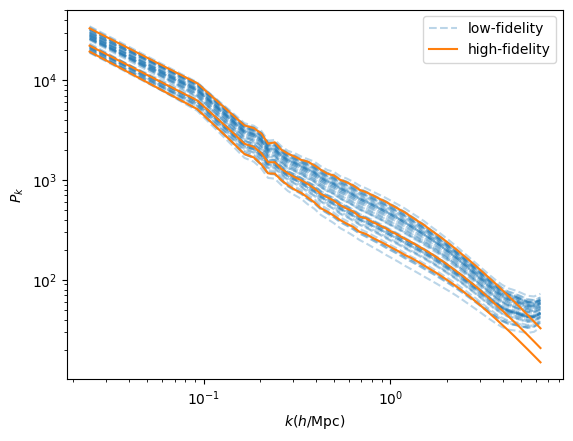

In [4]:
# visualize training spectra
for i,y_train in enumerate(data.Y_train[0]):
    if i == 0:
        plt.loglog(10**data.kf, 10**y_train, label="low-fidelity", color="C0", ls='--', alpha=0.3)
    else:
        plt.loglog(10**data.kf, 10**y_train, color="C0", ls='--', alpha=0.3)
for i,y_train in enumerate(data.Y_train[1]):
    if i == 0:
        plt.loglog(10**data.kf, 10**y_train, label="high-fidelity", color="C1")
    else:
        plt.loglog(10**data.kf, 10**y_train, color="C1")
plt.legend()
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k}$")


## Prepare 50LF-3HF multi-fidelity data 

In [5]:

# 🔹 1️⃣ Load Data
X_LF, Y_LF = data.X_train_norm[0], data.Y_train_norm[0]  # LF Data (50, 5) → (50, 49)
X_HF, Y_HF = data.X_train_norm[1], data.Y_train_norm[1]  # HF Data (3, 5) → (3, 49)
X_test_HF, Y_test_HF = data.X_test_norm[0], data.Y_test[0]  # Test HF Data (10, 5) → (10, 49)

# 🔹 2️⃣ Prepare Training Data
n_LF, n_HF = X_LF.shape[0], X_HF.shape[0]  # Number of points
output_dim = Y_LF.shape[1]  # 49 output dimensions

# Append fidelity indicators (0 for LF, 1 for HF)
X_LF_aug = np.hstack([X_LF, np.zeros((n_LF, 1))])  # Append 0 for LF
X_HF_aug = np.hstack([X_HF, np.ones((n_HF, 1))])   # Append 1 for HF

# Combine datasets
X_train = np.vstack([X_LF_aug, X_HF_aug])  # Shape: (53, 6)
Y_train = np.vstack([Y_LF, Y_HF])  # Shape: (53, 49)

# 🔹 3️⃣ Define Multi-Fidelity GP Model
kernel_L = gpflow.kernels.RBF(lengthscales=np.ones(5), variance=1.0)  # LF Kernel
kernel_delta = gpflow.kernels.RBF(lengthscales=np.ones(5), variance=1.0)  # Discrepancy Kernel

mf_gp = MultiFidelityGPModel(X_train, Y_train, kernel_L, kernel_delta)

# 🔹 4️⃣ Train the Model
mf_gp.optimize(max_iters=1000, use_adam=True, learning_rate=0.1, unfix_noise_after=500)


Optimizing with Adam...


2025-02-16 14:32:53.806360: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


🔹 Iteration 0: Loss = 1825.2620287500806
🔹 Iteration 100: Loss = 5108.897743849085
🔹 Iteration 200: Loss = 5177.507230805021
🔹 Iteration 300: Loss = 5213.291969936019
🔹 Iteration 400: Loss = 5237.003163123581
🔹 Unfixing noise at iteration 500
🔹 Iteration 500: Loss = 5254.116876204594
🔹 Iteration 600: Loss = 5267.122332906135
🔹 Iteration 700: Loss = 5277.382739759458
🔹 Iteration 800: Loss = 5285.705504799675
🔹 Iteration 900: Loss = 5292.602815722793


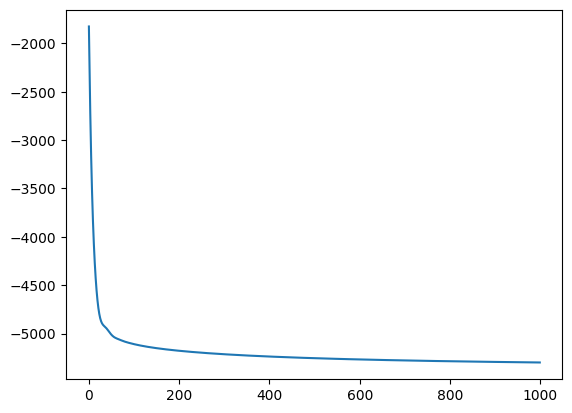

In [6]:
# loss history
plt.plot(mf_gp.loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")

Test on different outputs

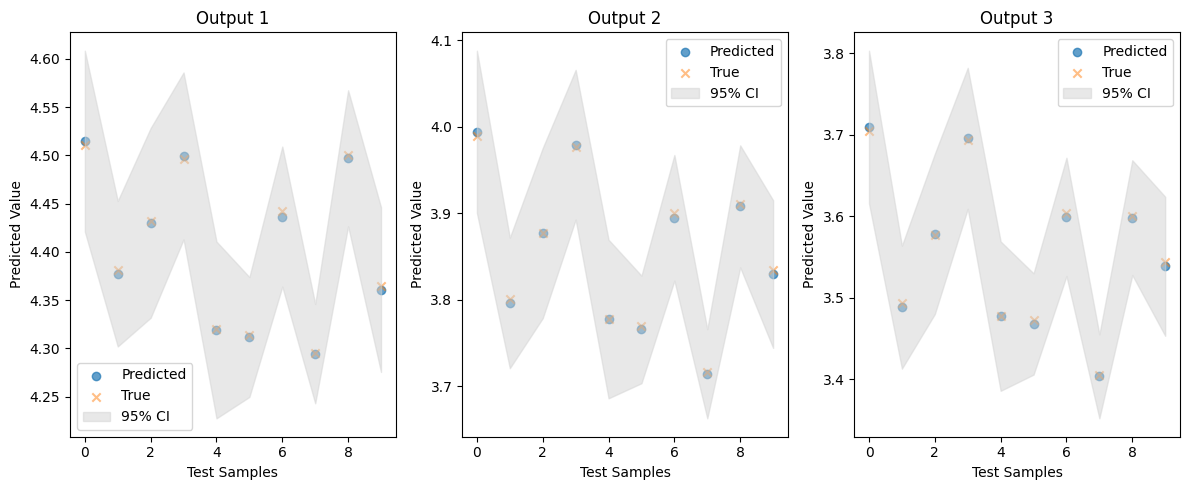

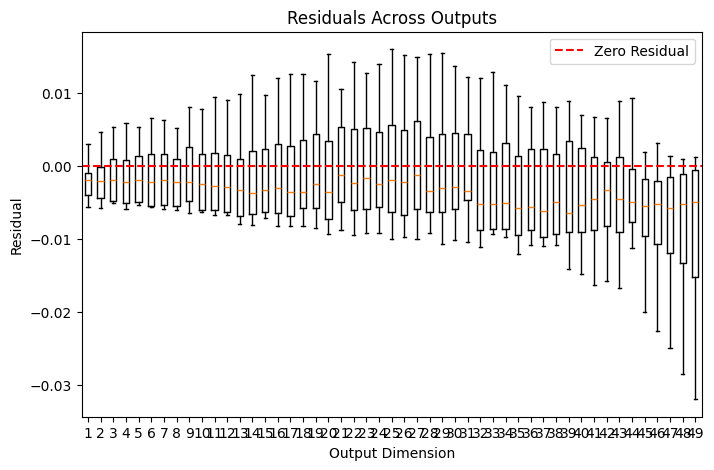

In [7]:

# 🔹 5️⃣ Make Predictions on HF Test Set
X_test_HF_aug = np.hstack([X_test_HF, np.ones((10, 1))])  # Add HF indicator (1)
mean_pred, var_pred = mf_gp.predict_f(X_test_HF_aug)  # Predict

# 🔹 6️⃣ Compute Residuals
residuals = mean_pred.numpy() - Y_test_HF  # Shape: (10, 49)

# 🔹 7️⃣ Plot Predictions for 3 Output Dimensions
plt.figure(figsize=(12, 5))

for i in range(3):  # Plot 3 output dimensions
    plt.subplot(1, 3, i+1)
    plt.scatter(np.arange(10), mean_pred[:, i], label="Predicted", alpha=0.7)
    plt.scatter(np.arange(10), Y_test_HF[:, i], label="True", alpha=0.5, marker="x")
    plt.fill_between(np.arange(10), 
                     (mean_pred[:, i] - 1.96 * np.sqrt(var_pred[:, i])).numpy(), 
                     (mean_pred[:, i] + 1.96 * np.sqrt(var_pred[:, i])).numpy(), 
                     color="lightgray", alpha=0.5, label="95% CI")
    plt.title(f"Output {i+1}")
    plt.xlabel("Test Samples")
    plt.ylabel("Predicted Value")
    plt.legend()

plt.tight_layout()
plt.show()

# 🔹 8️⃣ Residual Plot
plt.figure(figsize=(8, 5))
plt.boxplot(residuals, showfliers=False)
plt.axhline(0, linestyle="--", color="red", label="Zero Residual")
plt.title("Residuals Across Outputs")
plt.xlabel("Output Dimension")
plt.ylabel("Residual")
plt.legend()
plt.show()

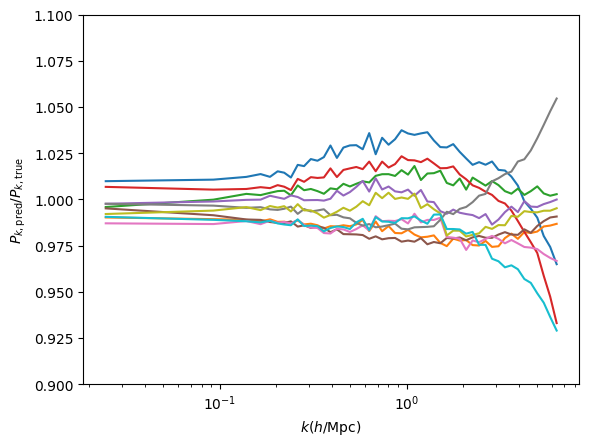

Text(0, 0.5, '$P_{k,\\mathrm{pred}}-P_{k,\\mathrm{true}}$')

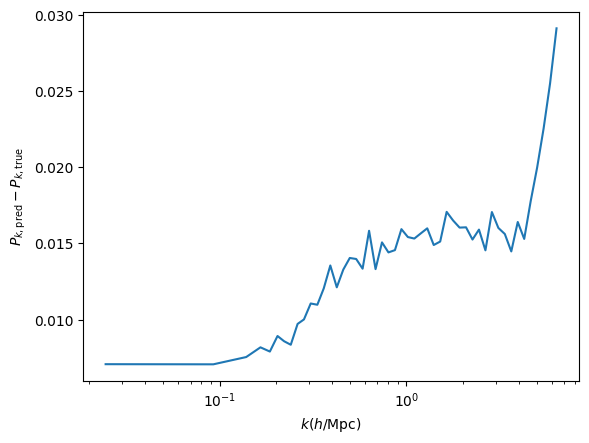

In [8]:
# Predicted vs True Plot across k
plt.semilogx(10**data.kf, (10**mean_pred/10**Y_test_HF).numpy().T);
plt.ylim(0.9, 1.1)
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k,\mathrm{pred}}/P_{k,\mathrm{true}}$")
plt.show()
# absolute error
plt.semilogx(10**data.kf, np.abs((10**mean_pred/10**Y_test_HF-1).numpy()).mean(axis=0));
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k,\mathrm{pred}}-P_{k,\mathrm{true}}$")